In [37]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
input_len, output_len = 20, 10 

In [73]:
data = pd.read_csv('flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                        features=select_features, covariates=False)
# features = getFeatures()

In [40]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 40, 7])
torch.Size([64, 20])


In [41]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)
        outputs = []
        for _ in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            output = self.fc(output) 
            outputs.append(output[:, :, -1].unsqueeze(2))
            x = output

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, output_len, lstm_num_hidden, num_layers)

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        h, c = self.encoder(x)
        xt = x[:, -1, :].unsqueeze(1) # input the last time step of x into the decoder
        outputs = self.decoder(xt, h, c) # (batch_size, output_len, 1)
        return outputs

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(select_features)
hidden_size = 32  
num_layers = 1


# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_len, output_len, [32, 32], hidden_size, num_layers=num_layers).to(device)

cuda


In [43]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 25
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        with torch.no_grad():
            outputs = seq2seq(inputs)  
            outputs = outputs.squeeze(-1) # (batch_size, output_len)
            loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_select2_best_model_{input_len}-{output_len}.pt')


Epoch 1/25 [TRAIN]: 100%|██████████| 2239/2239 [00:40<00:00, 54.90it/s, train_loss=0.0133] 


Epoch 1/25, Average Training Loss: 0.008454


Epoch 1/25 [VAL]: 100%|██████████| 750/750 [00:09<00:00, 82.25it/s, val_loss=0.00412]


Epoch 1/25, Average Validation Loss: 0.005658


Epoch 2/25 [TRAIN]: 100%|██████████| 2239/2239 [00:39<00:00, 56.32it/s, train_loss=0.00549]


Epoch 2/25, Average Training Loss: 0.005428


Epoch 2/25 [VAL]: 100%|██████████| 750/750 [00:09<00:00, 81.59it/s, val_loss=0.004]  


Epoch 2/25, Average Validation Loss: 0.004924


Epoch 3/25 [TRAIN]: 100%|██████████| 2239/2239 [00:40<00:00, 55.97it/s, train_loss=0.00409]


Epoch 3/25, Average Training Loss: 0.004857


Epoch 3/25 [VAL]: 100%|██████████| 750/750 [00:08<00:00, 86.09it/s, val_loss=0.00343]


Epoch 3/25, Average Validation Loss: 0.004372


Epoch 4/25 [TRAIN]: 100%|██████████| 2239/2239 [00:39<00:00, 56.10it/s, train_loss=0.00394]


Epoch 4/25, Average Training Loss: 0.004539


Epoch 4/25 [VAL]: 100%|██████████| 750/750 [00:09<00:00, 78.98it/s, val_loss=0.00367]


Epoch 4/25, Average Validation Loss: 0.004201


Epoch 5/25 [TRAIN]: 100%|██████████| 2239/2239 [00:44<00:00, 50.81it/s, train_loss=0.00578]


Epoch 5/25, Average Training Loss: 0.004293


Epoch 5/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 65.80it/s, val_loss=0.00367]


Epoch 5/25, Average Validation Loss: 0.004378


Epoch 6/25 [TRAIN]: 100%|██████████| 2239/2239 [00:50<00:00, 44.37it/s, train_loss=0.00538]


Epoch 6/25, Average Training Loss: 0.004190


Epoch 6/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 66.60it/s, val_loss=0.0035] 


Epoch 6/25, Average Validation Loss: 0.003925


Epoch 7/25 [TRAIN]: 100%|██████████| 2239/2239 [00:47<00:00, 47.03it/s, train_loss=0.00435]


Epoch 7/25, Average Training Loss: 0.004089


Epoch 7/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 65.05it/s, val_loss=0.00332]


Epoch 7/25, Average Validation Loss: 0.003830


Epoch 8/25 [TRAIN]: 100%|██████████| 2239/2239 [00:48<00:00, 45.72it/s, train_loss=0.00378]


Epoch 8/25, Average Training Loss: 0.004010


Epoch 8/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 67.10it/s, val_loss=0.00337]


Epoch 8/25, Average Validation Loss: 0.004002


Epoch 9/25 [TRAIN]: 100%|██████████| 2239/2239 [00:48<00:00, 46.49it/s, train_loss=0.00568]


Epoch 9/25, Average Training Loss: 0.003954


Epoch 9/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 64.06it/s, val_loss=0.00376]


Epoch 9/25, Average Validation Loss: 0.004168


Epoch 10/25 [TRAIN]: 100%|██████████| 2239/2239 [00:48<00:00, 45.75it/s, train_loss=0.00333]


Epoch 10/25, Average Training Loss: 0.003893


Epoch 10/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 63.01it/s, val_loss=0.00328]


Epoch 10/25, Average Validation Loss: 0.003884


Epoch 11/25 [TRAIN]: 100%|██████████| 2239/2239 [00:45<00:00, 48.76it/s, train_loss=0.00431]


Epoch 11/25, Average Training Loss: 0.003841


Epoch 11/25 [VAL]: 100%|██████████| 750/750 [00:10<00:00, 69.60it/s, val_loss=0.00313]


Epoch 11/25, Average Validation Loss: 0.003830


Epoch 12/25 [TRAIN]: 100%|██████████| 2239/2239 [00:45<00:00, 48.81it/s, train_loss=0.00318]


Epoch 12/25, Average Training Loss: 0.003801


Epoch 12/25 [VAL]: 100%|██████████| 750/750 [00:10<00:00, 69.19it/s, val_loss=0.00317]


Epoch 12/25, Average Validation Loss: 0.003852


Epoch 13/25 [TRAIN]: 100%|██████████| 2239/2239 [00:46<00:00, 48.55it/s, train_loss=0.00231]


Epoch 13/25, Average Training Loss: 0.003777


Epoch 13/25 [VAL]: 100%|██████████| 750/750 [00:10<00:00, 69.05it/s, val_loss=0.00308]


Epoch 13/25, Average Validation Loss: 0.003648


Epoch 14/25 [TRAIN]: 100%|██████████| 2239/2239 [00:46<00:00, 48.42it/s, train_loss=0.00298]


Epoch 14/25, Average Training Loss: 0.003732


Epoch 14/25 [VAL]: 100%|██████████| 750/750 [00:10<00:00, 69.14it/s, val_loss=0.00296]


Epoch 14/25, Average Validation Loss: 0.003780


Epoch 15/25 [TRAIN]: 100%|██████████| 2239/2239 [00:49<00:00, 44.82it/s, train_loss=0.0033] 


Epoch 15/25, Average Training Loss: 0.003695


Epoch 15/25 [VAL]: 100%|██████████| 750/750 [00:12<00:00, 61.68it/s, val_loss=0.00312]


Epoch 15/25, Average Validation Loss: 0.003655


Epoch 16/25 [TRAIN]: 100%|██████████| 2239/2239 [00:47<00:00, 47.04it/s, train_loss=0.00268]


Epoch 16/25, Average Training Loss: 0.003673


Epoch 16/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 67.20it/s, val_loss=0.00275]


Epoch 16/25, Average Validation Loss: 0.003614


Epoch 17/25 [TRAIN]: 100%|██████████| 2239/2239 [00:46<00:00, 48.48it/s, train_loss=0.00266]


Epoch 17/25, Average Training Loss: 0.003656


Epoch 17/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 67.36it/s, val_loss=0.00285]


Epoch 17/25, Average Validation Loss: 0.003574


Epoch 18/25 [TRAIN]: 100%|██████████| 2239/2239 [00:48<00:00, 46.15it/s, train_loss=0.00511]


Epoch 18/25, Average Training Loss: 0.003636


Epoch 18/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 65.05it/s, val_loss=0.00289]


Epoch 18/25, Average Validation Loss: 0.003782


Epoch 19/25 [TRAIN]: 100%|██████████| 2239/2239 [00:49<00:00, 45.67it/s, train_loss=0.00318]


Epoch 19/25, Average Training Loss: 0.003621


Epoch 19/25 [VAL]: 100%|██████████| 750/750 [00:10<00:00, 70.41it/s, val_loss=0.00269]


Epoch 19/25, Average Validation Loss: 0.003615


Epoch 20/25 [TRAIN]: 100%|██████████| 2239/2239 [00:46<00:00, 48.26it/s, train_loss=0.0037] 


Epoch 20/25, Average Training Loss: 0.003609


Epoch 20/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 63.07it/s, val_loss=0.00266]


Epoch 20/25, Average Validation Loss: 0.003554


Epoch 21/25 [TRAIN]: 100%|██████████| 2239/2239 [00:49<00:00, 45.29it/s, train_loss=0.00383]


Epoch 21/25, Average Training Loss: 0.003552


Epoch 21/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 65.25it/s, val_loss=0.00301]


Epoch 21/25, Average Validation Loss: 0.003566


Epoch 22/25 [TRAIN]: 100%|██████████| 2239/2239 [00:48<00:00, 46.64it/s, train_loss=0.00334]


Epoch 22/25, Average Training Loss: 0.003560


Epoch 22/25 [VAL]: 100%|██████████| 750/750 [00:12<00:00, 58.44it/s, val_loss=0.00269]


Epoch 22/25, Average Validation Loss: 0.003628


Epoch 23/25 [TRAIN]: 100%|██████████| 2239/2239 [00:48<00:00, 46.29it/s, train_loss=0.00258]


Epoch 23/25, Average Training Loss: 0.003540


Epoch 23/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 66.63it/s, val_loss=0.00265]


Epoch 23/25, Average Validation Loss: 0.003585


Epoch 24/25 [TRAIN]: 100%|██████████| 2239/2239 [00:47<00:00, 47.43it/s, train_loss=0.00653]


Epoch 24/25, Average Training Loss: 0.003526


Epoch 24/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 64.98it/s, val_loss=0.00273]


Epoch 24/25, Average Validation Loss: 0.003601


Epoch 25/25 [TRAIN]: 100%|██████████| 2239/2239 [00:46<00:00, 47.89it/s, train_loss=0.00342]


Epoch 25/25, Average Training Loss: 0.003495


Epoch 25/25 [VAL]: 100%|██████████| 750/750 [00:11<00:00, 66.94it/s, val_loss=0.00275]

Epoch 25/25, Average Validation Loss: 0.003565


Test loss: 0.003167317481711507
MAPE: 14.046120643615723


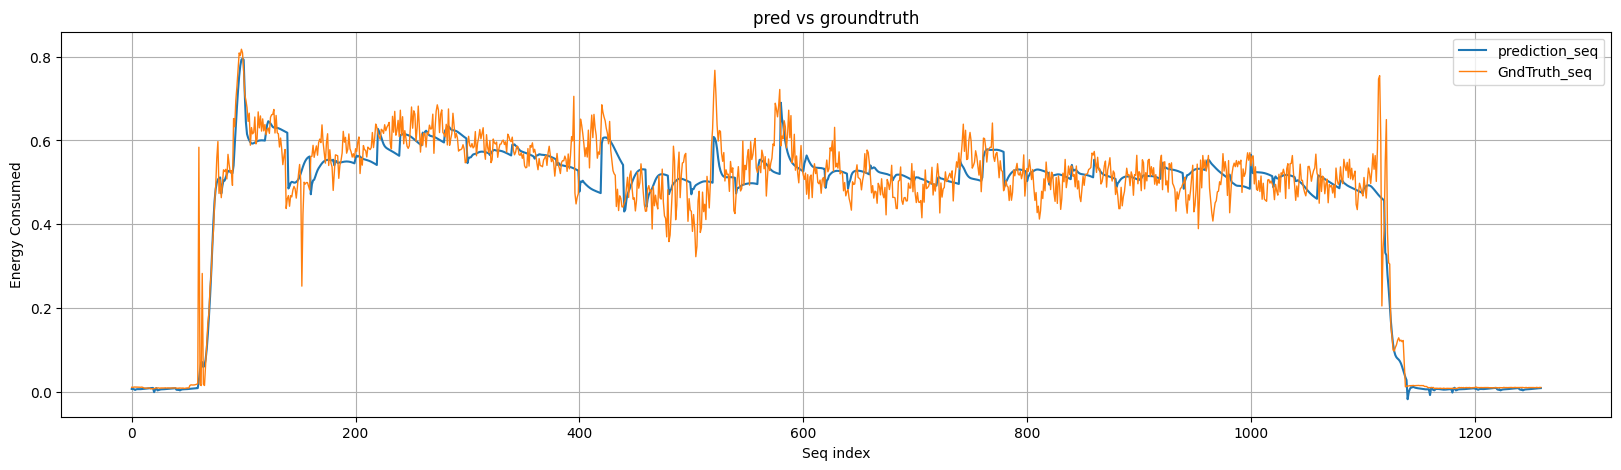

In [56]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
flight_num = 276 #random.randint(0, 100)
flight_num = random.choice(d_split['test'])
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                         test_data['power'].values,input_len,output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [81]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
mape_list = []
flights = d_split['test']
# flights.remove(273)
for flight_num in flights:
    # flight_num = 276 #random.randint(0, 100)
    test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.05)]
    input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values,input_len,output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)


    with torch.no_grad():
        
        outputs = seq2seq(input_seq)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq

        error = nn.MSELoss()(outputs, targets)
        # print(f"Test loss: {error}")

        mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
        # print(f"MAPE: {mape}")
        mape_list.append(mape)
        # plot_output(outputs.cpu(), targets.cpu(), output_len)

print(f"avg MAPE: {sum(mape_list)/len(mape_list)}")


avg MAPE: 8.661397933959961


In [69]:
from data_process import create_sequences
from utils import plot_output
import numpy as np

mape_list = []
for flight_num in flights:
    test_data = data[(data['flight'] == flight_num)]
    outputs = test_data['power'].mean()
    test_data = test_data[data['power'] > 0.05]

    # test_data.plot(x='time', y='power', figsize=(20, 5))

    
    targets = test_data['power'].values
    mape = np.mean(np.abs((outputs - targets) / targets)) * 100
    # print(f"MAPE: {mape}")
    mape_list.append(mape)

print(f"avg worst MAPE: {sum(mape_list)/len(mape_list)}")

avg worst MAPE: 27.943930572505742


In [ ]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
test_nums = d_split['test']
test_nums.remove(273)

for f_num in d_split['test']:
    test_data = data[data['flight'] == f_num]
    input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values,input_len,output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

    print(f"Flight {f_num}:")

    with torch.no_grad():
        
        outputs = seq2seq(input_seq)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq
    
        error = nn.MSELoss()(outputs, targets)
        print(f"Test loss: {error}")

        mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
        print(f"MAPE: {mape}")

Flight 3:
Test loss: 0.0047182063572108746
MAPE: 25.39449119567871
Flight 124:
Test loss: 0.004693096503615379
MAPE: 26.438045501708984
Flight 16:
Test loss: 0.003157896688207984
MAPE: 15.184256553649902
Flight 261:
Test loss: 0.002392771653831005
MAPE: 15.795760154724121
Flight 152:
Test loss: 0.0031380346044898033
MAPE: 13.142889976501465
Flight 94:
Test loss: 0.00228779180906713
MAPE: 14.196331977844238
Flight 254:
Test loss: 0.00353117729537189
MAPE: 39.42812728881836
Flight 262:
Test loss: 0.002715652110055089
MAPE: 14.624393463134766
Flight 135:
Test loss: 0.0031687517184764147
MAPE: 13.427847862243652
Flight 17:
Test loss: 0.004430381115525961
MAPE: 16.987926483154297
Flight 232:
Test loss: 0.004713214002549648
MAPE: 27.069053649902344
Flight 20:
Test loss: 0.004627623129636049
MAPE: 16.106483459472656
Flight 243:
Test loss: 0.002268434502184391
MAPE: 24.617231369018555
Flight 113:
Test loss: 0.005724154878407717
MAPE: 23.7071533203125
Flight 246:
Test loss: 0.001868801657110452

In [67]:
# test the model
seq2seq.eval()
mape_list = []

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)
        
    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    mape_list.append(mape.item())

print(f"Test MAPE: {sum(mape_list)/len(mape_list)}")


Test MAPE: 18.606854237192046


It seems LSTM-LSTM is better than current design of TCN-LSTM